In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tensorboardX import SummaryWriter

In [95]:
#network
b = 1. #initial translation
a = 1. #initial slope

#validation set
m = 10 #size
u, v = -10., 10. #domain [u, v]

#loss and optimizer
batchsize = 100
lr = 1e-3
iterations = 10000 #number of gradient descents
criterion = nn.MSELoss() #loss function
regularize = True #use gradient regularization

In [96]:
#network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc1.weight.data=torch.tensor([[1.], [1.]])
        self.fc1.bias.data=torch.tensor([0., -b])
        self.fc2 = nn.Linear(2, 1)
        self.fc2.weight.data=torch.tensor([[a, -a]])
        self.fc2.bias.data=torch.tensor([0.])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#tensorboard
writer = SummaryWriter()
    
#optimization
def optimize(iterations, net):
    
    #validation set
    x_val = torch.linspace(u, v, m).view(-1,1)
    y_val = torch.zeros(m, 1)
    
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    
    labels = torch.zeros(batchsize, 1)
    for i in range(iterations):  

            inputs = torch.FloatTensor(batchsize, 1).uniform_(u, v)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # gradient of output w.r.t. input
            if regularize:
                    grad_inputs = torch.FloatTensor(50000*batchsize, 1).uniform_(u, v)
                    grad_inputs.requires_grad = True
                    output = net(grad_inputs)
                    output.backward(torch.ones(grad_inputs.size()))        
                    loss = criterion(net(inputs), labels) + torch.max(abs(grad_inputs.grad))
            else:
                    loss = criterion(net(inputs), labels)
            
            
            # forward + backward + optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #tensorboard and print statistics
            for name, param_tensor in net.named_parameters():
                    writer.add_histogram(name, param_tensor.data.numpy(), i)
                    for num, parameter in enumerate(param_tensor.data.flatten()):
                            writer.add_scalar('parameter/'+name+str(num), parameter, i)
            valid_loss = criterion(net(x_val), y_val)
            error = torch.max(abs(net(x_val) - y_val))
            writer.add_scalars('metrics', {'valid_loss': valid_loss, 'max. error': error,
                                                 'batch_loss': loss}, i)
            
            
            if i % 500 == 499:    # print every 10 mini-batches
                loss = criterion(net(x_val), y_val)
                error = torch.max(abs(net(x_val) - y_val))
                print('iteration: %5d   loss: %.6f   max error: %.6f' %(i + 1, valid_loss, error))
    
    print('Finished Training')

In [97]:
#network
net=Net()
parameter=optimize(iterations, net)

iteration:   500   loss: 0.003154   max error: 0.114859
iteration:  1000   loss: 0.000152   max error: 0.025685
iteration:  1500   loss: 0.000007   max error: 0.005702
iteration:  2000   loss: 0.000000   max error: 0.001215
iteration:  2500   loss: 0.000000   max error: 0.000265
iteration:  3000   loss: 0.000000   max error: 0.000057
iteration:  3500   loss: 0.000000   max error: 0.000015
iteration:  4000   loss: 0.000000   max error: 0.000006
iteration:  4500   loss: 0.000000   max error: 0.000006
iteration:  5000   loss: 0.000000   max error: 0.000006
iteration:  5500   loss: 0.000000   max error: 0.000006
iteration:  6000   loss: 0.000000   max error: 0.000006
iteration:  6500   loss: 0.000000   max error: 0.000006
iteration:  7000   loss: 0.000000   max error: 0.000006
iteration:  7500   loss: 0.000000   max error: 0.000006
iteration:  8000   loss: 0.000000   max error: 0.000006
iteration:  8500   loss: 0.000000   max error: 0.000005
iteration:  9000   loss: 0.000000   max error: 0

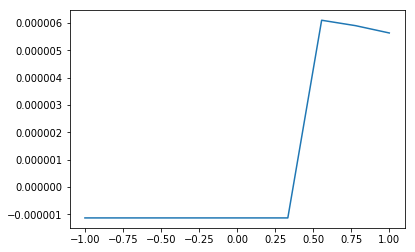

In [98]:
#plotting the predicted function

delta = -9.0 #increase interval by delta

x_plt = torch.linspace(u-delta, v+delta, m).view(-1,1)
with torch.no_grad():
    y_plt = net(x_plt)

plt.plot(x_plt.numpy(), y_plt.numpy())
plt.show()

In [85]:
for name, param_tensor in net.named_parameters():
        print(name)
        print(param_tensor)

fc1.weight
Parameter containing:
tensor([[0.8519],
        [1.0978]], requires_grad=True)
fc1.bias
Parameter containing:
tensor([-0.4702, -0.6059], requires_grad=True)
fc2.weight
Parameter containing:
tensor([[ 0.9689, -0.7519]], requires_grad=True)
fc2.bias
Parameter containing:
tensor([-1.1728e-06], requires_grad=True)


In [17]:
-0.47/0.84

-0.5595238095238095

In [18]:
-0.61/1.09

-0.5596330275229358

In [8]:
writer.close()
!tensorboard --logdir runs 

TensorBoard 1.13.1 at http://vong:6006 (Press CTRL+C to quit)
I0502 15:05:11.354992 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:11] "GET / HTTP/1.1" 200 -
I0502 15:05:11.406218 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:11] "GET /tf-interactive-inference-dashboard/editedexample.png HTTP/1.1" 200 -
I0502 15:05:11.409964 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:11] "GET /tf-interactive-inference-dashboard/distance.png HTTP/1.1" 200 -
I0502 15:05:11.411534 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:11] "GET /tf-interactive-inference-dashboard/explorecounterfactuals.png HTTP/1.1" 200 -
I0502 15:05:11.417875 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:11] "GET /tf-interactive-inference-dashboard/pdplots.png HTTP/1.1" 200 -
I0502 15:05:12.231487 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:12] "GET /data/experi

I0502 15:05:42.586440 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:05:42.612729 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:05:42.615376 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:05:42.622936 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fvalid_loss&experiment= HTTP/1.1" 200 -
I0502 15:05:42.623488 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:05:42] "GET /data/plugin/scalars/scalars?tag=m

I0502 15:06:42.550705 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:06:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:06:42.551224 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:06:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:06:42.551651 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:06:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:07:12.268745 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:07:12] "GET /data/runs HTTP/1.1" 200 -
I0502 15:07:12.269343 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:07:12] "GET /data/experiments HTTP/1.1" 200 -
I0502 15:07:12.269824 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019

I0502 15:08:12.490755 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:08:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fbatch_loss&experiment= HTTP/1.1" 200 -
I0502 15:08:12.501595 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:08:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:08:12.510798 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:08:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:08:12.534185 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:08:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:08:12.534586 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:08:12] "GET /data/plugin/scalars/scalars?tag=par

I0502 15:09:42.499649 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:09:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:09:42.527212 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:09:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:09:42.539969 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:09:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:09:42.548501 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:09:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:09:42.549082 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:09:42] "GET /data/plugin/scalars/scalars?tag=paramete

I0502 15:11:12.531218 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:11:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fmax.+error&experiment= HTTP/1.1" 200 -
I0502 15:11:12.539316 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:11:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fbatch_loss&experiment= HTTP/1.1" 200 -
I0502 15:11:12.580214 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:11:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:11:12.598452 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:11:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:11:12.599049 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:11:12] "GET /data/plugin/scalars/scalar

I0502 15:12:42.527563 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:12:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:12:42.557399 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:12:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:12:42.557939 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:12:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:12:42.558269 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:12:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:12:42.559020 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:12:42] "GET /data/plugin/scalars/scalars?tag=paramete

I0502 15:14:12.486940 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:14:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fmax.+error&experiment= HTTP/1.1" 200 -
I0502 15:14:12.492439 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:14:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:14:12.555506 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:14:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:14:12.563096 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:14:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:14:12.563591 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:14:12] "GET /data/plugin/scalars/scalars?tag

I0502 15:15:42.461002 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:15:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fmax.+error&experiment= HTTP/1.1" 200 -
I0502 15:15:42.510185 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:15:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fvalid_loss&experiment= HTTP/1.1" 200 -
I0502 15:15:42.515631 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:15:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.bias1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:15:42.521039 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:15:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:15:42.528964 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:15:42] "GET /data/plugin/scalars/scalar

I0502 15:17:12.500166 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:17:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fmax.+error&experiment= HTTP/1.1" 200 -
I0502 15:17:12.500697 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:17:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fvalid_loss&experiment= HTTP/1.1" 200 -
I0502 15:17:12.511571 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:17:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:17:12.511996 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:17:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:17:12.517438 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:17:12] "GET /data/plugin/scalars/scalar

I0502 15:18:42.321669 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:18:42] "GET /data/runs HTTP/1.1" 200 -
I0502 15:18:42.322395 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:18:42] "GET /data/environment HTTP/1.1" 200 -
I0502 15:18:42.323267 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:18:42] "GET /data/plugins_listing HTTP/1.1" 200 -
I0502 15:18:42.323508 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:18:42] "GET /data/experiments HTTP/1.1" 200 -
I0502 15:18:42.340779 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:18:42] "GET /data/plugin/scalars/tags HTTP/1.1" 200 -
I0502 15:18:42.519590 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:18:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fvalid_loss&experiment= HTTP/1.1" 200 -
I0502 15:18:42.525914 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [0

I0502 15:19:42.639081 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:19:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:19:42.639673 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:19:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:20:12.326761 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:20:12] "GET /data/runs HTTP/1.1" 200 -
I0502 15:20:12.327020 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:20:12] "GET /data/environment HTTP/1.1" 200 -
I0502 15:20:12.327927 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:20:12] "GET /data/experiments HTTP/1.1" 200 -
I0502 15:20:12.328171 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:20:12] "GET /data/plugins_listing HTTP/1.1" 200 -
I0502 15:20:12.3455

I0502 15:21:12.601009 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:21:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:21:12.609043 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:21:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:21:12.617029 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:21:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:21:12.617528 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:21:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:21:42.333101 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:21:42] "GET /data/runs HTTP/1.1" 200 -
I0502 15:21:42

I0502 15:22:42.576707 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:22:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fmax.+error&experiment= HTTP/1.1" 200 -
I0502 15:22:42.613643 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:22:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:22:42.629068 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:22:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:22:42.631400 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:22:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:22:42.631952 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:22:42] "GET /data/plugin/scalars/scalars?tag=p

I0502 15:24:12.601418 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:24:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:24:12.601820 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:24:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:24:12.606970 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:24:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:24:12.607650 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:24:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:24:42.349436 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:24:42] "GET /data/environment HTTP/1.1" 200 -
I0502 1

I0502 15:25:42.594773 139829125297920 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:25:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:25:42.595414 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:25:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:25:42.595768 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:25:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:25:42.596205 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:25:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc2.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:26:12.349811 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:26:12] "GET /data/environment HTTP/1.1" 200 -
I0502 1

I0502 15:27:12.592632 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:27:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:27:12.593008 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:27:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.weight1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:27:12.596350 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:27:12] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.bias1&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:27:12.601914 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:27:12] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fvalid_loss&experiment= HTTP/1.1" 200 -
I0502 15:27:12.634146 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:27:12] "GET /data/plugin/scalars/scalars?tag=p

I0502 15:28:42.597718 139829854672640 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:28:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fbatch_loss&experiment= HTTP/1.1" 200 -
I0502 15:28:42.598074 139829779171072 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:28:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fvalid_loss&experiment= HTTP/1.1" 200 -
I0502 15:28:42.598369 139829167515392 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:28:42] "GET /data/plugin/scalars/scalars?tag=metrics&run=May02_15-03-31_vong%2Fmetrics%2Fmax.+error&experiment= HTTP/1.1" 200 -
I0502 15:28:42.598761 139829116905216 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:28:42] "GET /data/plugin/scalars/scalars?tag=parameter%2Ffc1.bias0&run=May02_15-03-31_vong&experiment= HTTP/1.1" 200 -
I0502 15:28:42.599094 139829737223936 _internal.py:122] ::ffff:127.0.0.1 - - [02/May/2019 15:28:42] "GET /data/plugin/scalars

In [1]:
!rm -rf runs #remove old runs